<a href="https://colab.research.google.com/github/A125X/AI-notebooks/blob/main/btc_lstm_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List
from tqdm.keras import TqdmCallback

In [ ]:
df = pd.read_csv("BTC-Daily.csv", parse_dates=["date"])

In [ ]:
df.shape

(2651, 9)

In [ ]:
df.head(5)

unix       date   symbol      open      high       low     close  \
0  1646092800 2022-03-01  BTC/USD  43221.71  43626.49  43185.48  43185.48   
1  1646006400 2022-02-28  BTC/USD  37717.10  44256.08  37468.99  43178.98   
2  1645920000 2022-02-27  BTC/USD  39146.66  39886.92  37015.74  37712.68   
3  1645833600 2022-02-26  BTC/USD  39242.64  40330.99  38600.00  39146.66   
4  1645747200 2022-02-25  BTC/USD  38360.93  39727.97  38027.61  39231.64   

    Volume BTC    Volume USD  
0    49.006289  2.116360e+06  
1  3160.618070  1.364723e+08  
2  1701.817043  6.418008e+07  
3   912.724087  3.573010e+07  
4  2202.851827  8.642149e+07

In [ ]:
df["date"].min(), df["date"].max()

(Timestamp('2014-11-28 00:00:00'), Timestamp('2022-03-01 00:00:00'))

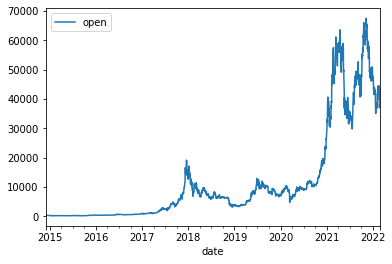

In [ ]:
df.plot(x="date", y="open")

In [ ]:
df_6_yr = df[df["date"] > df["date"].max() - timedelta(days=365 * 6)]

In [ ]:
df_6_yr.shape

(2190, 9)

In [ ]:
df_6_yr["date"].min(), df_6_yr["date"].max()

(Timestamp('2016-03-03 00:00:00'), Timestamp('2022-03-01 00:00:00'))

In [ ]:
'''
train_size = int(df_6_yr.shape[0] * 0.8)
train_df = df_6_yr.iloc[:train_size]
val_df = df_6_yr.iloc[train_size:]
'''

train_size = int(df.shape[0] * 0.8)
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:]

In [ ]:
train_df.shape, val_df.shape

((2120, 9), (531, 9))

In [ ]:
train_df["date"].min(), train_df["date"].max(), val_df["date"].min(), val_df["date"].max()

(Timestamp('2016-05-12 00:00:00'),
 Timestamp('2022-03-01 00:00:00'),
 Timestamp('2014-11-28 00:00:00'),
 Timestamp('2016-05-11 00:00:00'))

In [ ]:
scaler = StandardScaler()
scaler.fit(train_df[["close"]])

def make_dataset(
    df,
    window_size, 
    batch_size,
    use_scaler=True,
    shuffle=True
    ):
    features = df[["close"]].iloc[:-window_size]
    if use_scaler:
        features = scaler.transform(features)
    data = np.array(features, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=df["close"].iloc[window_size:],
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size)
    return ds

In [ ]:
train_df["close"].iloc[::-1]

2119      454.92
2118      456.04
2117      455.38
2116      457.48
2115      455.56
          ...   
4       39231.64
3       39146.66
2       37712.68
1       43178.98
0       43185.48
Name: close, Length: 2120, dtype: float64

In [ ]:
window_size = 20
batch_size = 90
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(4, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
    ])

lstm_model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )
history = lstm_model.fit(
      train_ds, 
      epochs=2000,
      validation_data=val_ds,
      verbose=0, 
      callbacks=[TqdmCallback(verbose=2)]
      )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]

In [ ]:
lstm_model.evaluate(train_ds)

24/24 [==============================] - 1s 29ms/step - loss: 486111072.0000 - mean_absolute_error: 14084.2998


[486111072.0, 14084.2998046875]

In [ ]:
lstm_model.evaluate(val_ds)

6/6 [==============================] - 0s 17ms/step - loss: 8797.4170 - mean_absolute_error: 86.1836


[8797.4169921875, 86.18358612060547]

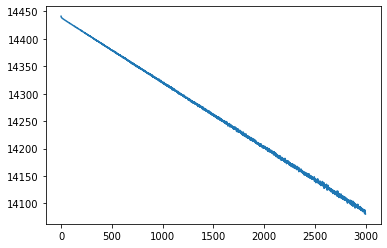

In [ ]:
plt.plot(history.history['mean_absolute_error'])

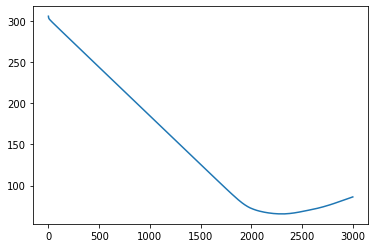

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])

In [ ]:
lstm_model.save('')

21/21 [==============================] - 3s 9ms/step


array([[357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082]], dtype=float32)

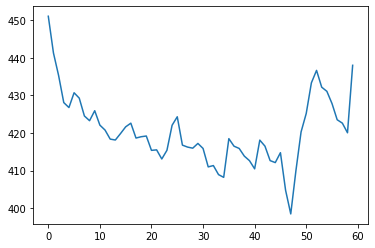

In [ ]:
test_ds = make_dataset(
    df=val_df[20:80], 
    window_size=window_size, 
    batch_size=1, 
    use_scaler=True, 
    shuffle=False)


plt.plot([n for n in range(60)], val_df[20:80]['close'])

lstm_model.predict(test_ds)

21/21 [==============================] - 0s 9ms/step


array([[357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082],
       [357.09082]], dtype=float32)

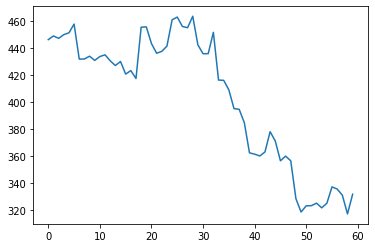

In [ ]:
test_ds = make_dataset(
    df=val_df[120:180], 
    window_size=window_size, 
    batch_size=1, 
    use_scaler=True, 
    shuffle=False)


plt.plot([n for n in range(60)], val_df[120:180]['close'])

lstm_model.predict(test_ds)